In [28]:
%matplotlib inline 
import random # 随机梯度下降
import torch 
from d2l import torch as d2l

# torch.cuda.is_available()

## 构造数据集

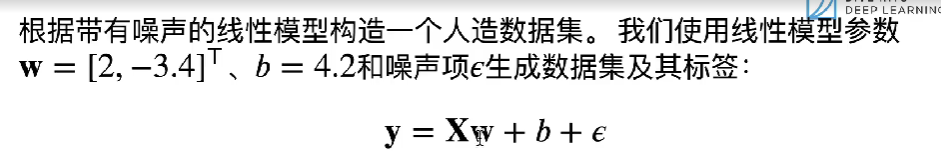

自己构造的数据集可以用来很方便验证模型的有效性 减去繁琐的数据分析过程

对于torch.normal的用法 如下 指定均值 方差 size 就可以创建一个tensor序列 随机

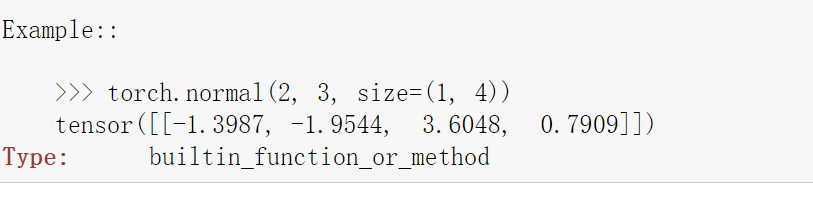

In [29]:
# num_examples 决定的是数据集的数量 生成多少组数据
def synthetic_data (w, b, num_examples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0, 1, size=(num_examples, len(w))) # 指定size 来生成一个随机的X序列 
    y = torch.matmul(X, w) + b # 根据权重向量构造出y的值
    y += torch.normal(0, 0.01, y.shape) # 给y增加一些随机浮动
    return X, y.reshape((-1, 1)) # 这里的reshape是什么意思？


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


In [30]:
features

tensor([[ 1.5879, -0.9882],
        [-0.7092,  1.0971],
        [ 0.6609, -0.8278],
        ...,
        [-0.4287,  0.1970],
        [ 0.3346,  0.8693],
        [ 1.1812,  1.0858]])

可以看到 y.reshape((-1, 1)) 实际上是将y的col固定为1 然后行则随意变换 自适应 适合那种构造一个列 然后自动调整为一个矩阵的那种类型

因为线性回归涉及到一些计算 所以reshape为(1000, 1)形状的矩阵会比较适应X的torch.Size(1000, 2)


In [31]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [32]:
# 这是我自己的实现
def data_gen(w, b, num_of_data): 
    X = torch.normal(0, 1, (num_of_data, len(w))) # 根据w 和传入的num 来生成 对应的features
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.001, y.shape) # 根据y的shape来生成 随机添加一些bias 
    return X, y.reshape(-1, 1)

In [33]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = data_gen(true_w, true_b, 1000)

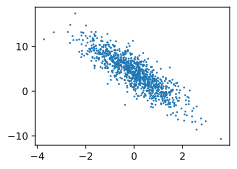

In [34]:
# 进行可视化
d2l.set_figsize()
# 只是第一列和labels 
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
# 因为画图是matplotlib 所以要将features 的tensor转到 numpy 中 
# 一些版本可能需要进行detach 然后再numpy进行转换

## 批量读取

因为整个处理比较耗费内存 所以我们需要一小块一小块进行处理 这也是深度学习的思想
所以我们 需要定义一个可以随机抽取批量的一个函数 进行批量随机梯度下降

tensor([[ 1.5148, -1.0888],
        [-0.4354, -1.2298],
        [ 0.0526,  2.1433],
        [-1.6607,  0.9054],
        [-0.0601, -0.2201],
        [-0.7963, -0.7923],
        [ 2.8242,  0.9495],
        [-0.6581, -2.5125],
        [ 0.6280,  0.0888],
        [-0.1216,  0.1471]]) 
 tensor([[10.9314],
        [ 7.5104],
        [-2.9814],
        [-2.2013],
        [ 4.8279],
        [ 5.3004],
        [ 6.6195],
        [11.4283],
        [ 5.1542],
        [ 3.4557]])


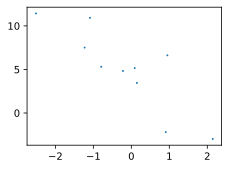

In [35]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) # 获取整个数据长度
    indices = list(range(num_examples)) # 生成一个数据列表
    random.shuffle(indices) # 将数据的索引打乱 根据这个乱序的索引来访问数据
    for i in range(0, num_examples, batch_size):
        # 这里的min 处理可以避免越界 因为i 和 batch_size 相加的大小是未知的 很可能超越num_examples
        # 这里的min 也同时导致了最后一个batch的不完整性 对于一些输入形状敏感型网络来说 会产生error
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])

        # yield 一个批量大小的数据 注意是一个iterator 所以要yield
        yield features[batch_indices], labels[batch_indices] # 保证features和labels的匹配
        
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    
    d2l.set_figsize()
    # 只是第一列和labels 
    d2l.plt.scatter(X[:, 1].detach().numpy(), y.detach().numpy(), 1)
    break

    
# 尽管整个数据集比较大 但是经过随机batch 之后 整个数据集实际上就变小了
# 处理起来也就更加方便

In [36]:
# 因为使用了yield关键字 所以会产生一个生成器 而不是一个直接的list 需要使用一定的方法进行转换 这是python特性

data_iter(batch_size, features, labels)

for data in data_iter(batch_size, features, labels):
    features, labels = data
    print(features)
    print(labels)

tensor([[ 1.6351,  0.2478],
        [-0.8149, -0.2047],
        [ 0.5195,  1.7267],
        [-1.7374,  0.4675],
        [ 0.2309, -0.8814],
        [ 0.9652,  0.5638],
        [-1.3690,  0.0211],
        [-0.2027,  1.3512],
        [ 1.4403,  0.3384],
        [-2.0178,  2.5775]])
tensor([[ 6.6288],
        [ 3.2658],
        [-0.6298],
        [-0.8653],
        [ 7.6600],
        [ 4.2126],
        [ 1.3929],
        [-0.7985],
        [ 5.9301],
        [-8.5977]])
tensor([[-0.4585, -1.8180],
        [-0.2382, -1.4052],
        [-0.6782,  0.3646],
        [ 0.8676, -2.0953],
        [ 0.5782,  2.5837],
        [ 0.6706, -1.4107],
        [ 0.9709, -0.5213],
        [-0.2388, -0.4380],
        [ 0.5567,  0.4056],
        [ 0.3256, -0.4444]])
tensor([[ 9.4633],
        [ 8.5005],
        [ 1.6040],
        [13.0577],
        [-3.4291],
        [10.3380],
        [ 7.9135],
        [ 5.2100],
        [ 3.9342],
        [ 6.3614]])
tensor([[-0.2870, -1.2422],
        [-0.4610,  0.5783],


## 模型初始化

我们使用的是梯度下降 来求解w 但是也要首先给一个初值 才能不断调整 不断下降

In [37]:
w = torch.normal(0, 0.1, size=(2, 1), requires_grad = True) # 因为要求解梯度
b = torch.zeros(1, requires_grad = True)
# 为何这两个都需要计算梯度？？ 因为这两个都是参数 需要计算梯度来更新一个更合适的网络


In [38]:
w, b
# w的形状是一个(2,1)size的内容

(tensor([[0.1152],
         [0.1873]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [39]:
def linreg(X, w, b):
    """线性回归模型"""
    # forward propagation
    return torch.matmul(X, w) + b

# 根据输入来计算出拟合的值 这就是value的计算方式 也就是一种最优化函数？

## loss function

定义好了一个简单的线性模型之后 我们还需要定义损失函数 来求解出损失函数最小的w 和 b

In [40]:
def squared_loss(y_hat, y):
    """均方损失 MSE """ 
    return (y_hat - y.reshape(y_hat.shape))**2 / 2 / batch_size# 会得到一个什么？

# 为什么可以这样？ 实际上这里/ 或者 不/ batchsize 都可以 只是将loss一定程度地缩小了 

## Modify function

定义一个优化算法 利用梯度下降进行

损失函数对这个更新公式的关系在于，我们通过计算损失函数对参数的梯度，即 param.grad，来确定参数在梯度方向上的下降幅度。然后，乘以学习率 lr 对梯度进行缩放，以控制参数更新的步幅。最后，除以批次大小 batch_size，以对梯度进行平均。

这个更新公式的目的是根据损失函数的梯度方向对参数进行调整，使得损失函数逐渐减小。通过使用梯度下降算法，我们尝试沿着损失函数的梯度最陡峭的方向来调整参数，从而使模型逼近最优解。

这里除以批次大小 batch_size 是为了对梯度进行平均。当使用小批量随机梯度下降时，参数的梯度是基于每个小批量样本计算的，而不是整个训练集。通过对梯度进行平均，可以减小更新步幅的变化，并更稳定地朝着最优解的方向前进。

In [41]:
# 因为我们的loss function计算的是一个总的误差 而不是一个平均 
# 所以下面的梯度下降的参数计算要计算平均

def SGD(params, lr, batch_size):
    """小批量随机梯度下降"""
    # close the gradient just for update
    with torch.no_grad():
        # 利用学习率 和 参数的梯度 来进行下降
        for param in params:
            param -= lr * param.grad  # 这里就是在计算一个平均下降
            param.grad.zero_() # 清除torch的自动累积
            

## 模型的训练

我们上述定义的模型、损失函数等都要用上 
首先要设置一个初始超参数 lr num_epochs 等等
我们的网络net 是linreg 就是简单的线性回归
loss 是 squared_loss 均方损失函数

In [42]:
w = torch.normal(0, 0.1, size=(2, 1), requires_grad = True) # 因为要求解梯度
b = torch.zeros(1, requires_grad = True)

# 求解w和b沿着梯度下降最快的方向 下降

lr = 0.01
num_epochs = 10 # 训练次数 和 batchsize是不同的 对相同的数据集反复训练 反复提取
loss = squared_loss # loss function
net = linreg # linred function forward

# 计算损失函数 然后计算出这两个的梯度 损失函数是跟这两个有关的 然后计算梯度 看哪个方向下降最快

# 分批量操作
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        """这里利用小批量随机梯度下降的方法 抽样出特定的batch 这里data_iter 是随机的
            w 和 b都是上面进行初始化之后
        """
        l = loss(net(X, w, b), y) # 计算小批量损失
        l.sum().backward() # 求和 对标量计算梯度 这里求和所以下面要进行平均
        SGD(([w, b]), lr, batch_size) # 利用参数的梯度进行更新 上述sgd 接受的就是一个参数列表 
    
    # 训练完一次之后 查看当前的loss情况 可以理解为一种在test集合上的表现
    with torch.no_grad():
        # net就是神经网络 也是用来衡量参数的优化程度的 实际上就是一个函数
        train_1 = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_1.mean()):f}') 
        # 计算一个均值 tarin_1 会计算一个损失值向量


# Summary: 需要一个前馈神经网络 然后需要loss 来衡量 以及一个优化器 在执行反向传播的过程中 利用loss来求解梯度 然后利用优化器来更新参数

epoch 1, loss 1.053053
epoch 2, loss 1.039566
epoch 3, loss 1.026266
epoch 4, loss 1.013151
epoch 5, loss 1.000217
epoch 6, loss 0.987461
epoch 7, loss 0.974881
epoch 8, loss 0.962474
epoch 9, loss 0.950237
epoch 10, loss 0.938168


In [43]:
true_w - w.reshape(true_w.shape)

tensor([ 2.0950, -3.2737], grad_fn=<SubBackward0>)

In [44]:
true_b - b

tensor([3.9857], grad_fn=<RsubBackward1>)

# 线性回归的简单实现

上面我们定义了随机batch 然后还定义了loss 以及 train的model 但这个模型实际上可以由深度学习框架来帮我们简单完成 不需要我们进行复杂定义

In [45]:
import numpy as np
import torch
from d2l import torch as d2l
from torch.utils import data
# 引入一些数据预处理的pkg帮助我们


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
# 仍然生成一些人工数据

In [46]:
# 我们的随机梯度下降 随机抽取数据 可以利用tensor 中的库来实现

def load_array(data_arrays, batch_size, is_train=True):
    """构造一个torch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays) # 传入的是一个数组 需要使用位置来引用
    return data.DataLoader(dataset, batch_size, shuffle=is_train) # 利用dataloader 自动进行抽样 然后设置shuffle是否打乱

batch_size = 10

# 这里数据尽管也是一个batch 一个batch的 但是实际上是由tensor内置的dataloader处理得到的
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter)) # 仍然构造了一个iter 使用起来差不多 但是dataloader 会更好



[tensor([[-0.3308,  0.2012],
         [-0.8199,  0.3979],
         [-0.4371,  0.0366],
         [ 1.7299,  0.5203],
         [ 1.3932, -1.5509],
         [-0.7275,  1.3124],
         [-0.8369,  1.4315],
         [-0.5323, -1.4381],
         [ 0.9234,  0.6645],
         [-0.2839,  1.3719]]),
 tensor([[ 2.8425],
         [ 1.2209],
         [ 3.1887],
         [ 5.8922],
         [12.2562],
         [-1.7213],
         [-2.3326],
         [ 8.0304],
         [ 3.8042],
         [-1.0079]])]

In [47]:
# 利用自带的神经网络进行定义
from torch import nn

# 输入特征为2个 output则为1个 
net = nn.Sequential(nn.Linear(2, 1)) # 一系列的层 线性模型我们只简单定义

# 初始化参数 
# net[0].weight和net[0].bias分别表示模型的权重w和偏置参数b
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 权重和偏置

权重和偏置参数在神经网络模型中是通用的概念，但具体的实现方式和用途可能因不同的神经网络模型而异。以下是一些常见的神经网络模型中的权重和偏置参数的用途：

全连接层（Fully Connected Layer）：全连接层是最简单的神经网络层，其中每个神经元都与上一层的所有神经元连接。在全连接层中，权重参数用于调整输入特征的权重，而偏置参数则用于引入偏移或基准值。

卷积神经网络（Convolutional Neural Network, CNN）：在卷积神经网络中，权重参数用于定义卷积核（filter）的权重，用于进行特征提取。不同的卷积核可以学习到不同的特征。偏置参数用于引入每个卷积核的偏置项。

循环神经网络（Recurrent Neural Network, RNN）：在循环神经网络中，权重参数用于定义循环连接的权重，用于记忆和传递信息。偏置参数用于引入每个时间步的偏置项。

对于上述简单线性模型来说 这两个很容易理解

In [48]:
# 均方误差 loss = nn.MSELoss() 这是自带的
# SGD 随机梯度下降 也有对应的算法 torch.optim.SGD(xxx)

loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr = 0.03) # 直接传入对应的net的paramters 进行训练
# 创建训练器 利用自带的SGD方法

trainer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [49]:
# data_iter 是已经处理好了的 可以直接使用
num_epochs = 10
for epoch in range(num_epochs):
    """对每个epoch进行训练"""
    for X, y in data_iter:
        l = loss(net(X), y) # 利用网络计算偏差值和真实值 因为定义好了一个net 不需要传入w 和 b 会直接训练好模型 在网络中
        trainer.zero_grad() # 梯度清零
        l.backward() # 计算梯度 torch已经做了sum
        trainer.step() # 进行梯度下降
    l = loss(net(features), labels) # 利用训练好的网络进行推算 计算误差的变化
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000179
epoch 2, loss 0.000101
epoch 3, loss 0.000101
epoch 4, loss 0.000101
epoch 5, loss 0.000101
epoch 6, loss 0.000101
epoch 7, loss 0.000101
epoch 8, loss 0.000101
epoch 9, loss 0.000101
epoch 10, loss 0.000101
